In [1]:
# Adapted from: Chapter 7 and 8 of Deep Learning with Pytorch by Eli Stevens (2020)
try:
    import torch as t
    import torch.nn as tnn
except ImportError:
    print("Colab users: pytorch comes preinstalled. Select Change Ru")
    print("Local users: Please install pytorch for your hardware using instructions from here: https://pytorch.org/get-started/locally/")
    print("ACG users: Please follow instructions here: https://vikasdhiman.info/ECE490-Neural-Networks/posts/0000-00-06-acg-slurm-jupyter/")
    
    raise

if t.cuda.is_available():
    DEVICE="cuda"
elif t.mps.is_available():
    DEVICE="mps"
else:
    DEVICE="cpu"
    
DTYPE = t.get_default_dtype()

In [2]:
## Doing it the Pytorch way without using our custom feature extraction

import torch
import torch.nn
import torch.optim
import torchvision
from torchvision.transforms import ToTensor, Compose, Normalize
from torch.utils.data import DataLoader

torch.manual_seed(17)
DATASET_MEAN = [0.4914, 0.4822, 0.4465]
DATASET_STD = [0.2470, 0.2435, 0.2616]
# Getting the dataset, the Pytorch way
all_training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(),
                       Normalize(DATASET_MEAN, # dataset mean
                                 DATASET_STD)]) # dataset std
)

test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(),
                       Normalize(DATASET_MEAN, # dataset mean
                                 DATASET_STD)]) # dataset std
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
training_data, validation_data = torch.utils.data.random_split(all_training_data, [0.9, 0.1])

![](imgs/cifar10.png)

In [4]:
img, label = all_training_data[99]
img.shape, label


(torch.Size([3, 32, 32]), 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


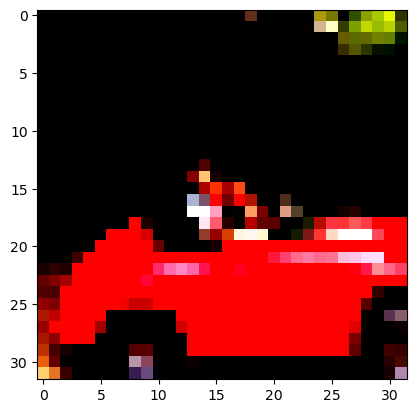

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0))

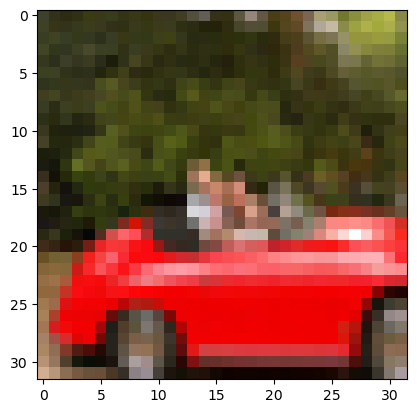

In [6]:
plt.imshow((img.permute(1, 2, 0) *  torch.Tensor(DATASET_STD)
            +  torch.Tensor(DATASET_MEAN)))

In [7]:
imgs = torch.stack([img_t for img_t, _ in all_training_data], dim=3)
imgs.reshape(3, -1).mean(dim=-1), imgs.reshape(3, -1).std(dim=-1)

(tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04]),
 tensor([1.0001, 0.9999, 1.0000]))

In [8]:
import pickle
cifar_meta = pickle.load(open("data/cifar-10-batches-py/batches.meta", "rb"), encoding='bytes')
class_names = [c.decode('utf-8') for c in cifar_meta[b'label_names']]
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
# Hyper parameters
learning_rate = 1e-3 # controls how fast the gradient descent goes
batch_size = 64
epochs = 5
momentum = 0.9

training_dataloader = DataLoader(training_data, shuffle=True, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data,  batch_size=batch_size)
test_dataloader = DataLoader(test_data,  batch_size=batch_size)
X, y = next(iter(training_dataloader))
X.shape

torch.Size([64, 3, 32, 32])

In [10]:
!pip install tensorboard

In [17]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 543069), started 0:05:49 ago. (Use '!kill 543069' to kill it.)

In [22]:
from torch.utils.tensorboard import SummaryWriter
import os
writer = SummaryWriter()

loss = torch.nn.CrossEntropyLoss()
# TODO:
# Define model = ?

model = tnn.Sequential(
    torch.nn.Flatten(),
    tnn.Linear(3*32*32, 100),
    tnn.ReLU(),
    tnn.Linear(100, 10))


# Define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

def loss_and_accuracy(model, loss, validation_dataloader, device=DEVICE):
        # Validation loop
        validation_size = len(validation_dataloader.dataset)
        num_batches = len(validation_dataloader)
        test_loss, correct = 0, 0
        
        with torch.no_grad():
            model.eval() # Put model in eval mode, affects layers like dropout and batchnorm
            for X, y in validation_dataloader:
                X = X.to(device)
                y = y.to(device)
                pred = model(X)
                test_loss += loss(pred, y)
                correct += (pred.argmax(dim=-1) == y).type(DTYPE).sum()

        test_loss /= num_batches
        correct /= validation_size
        return test_loss, correct
    
def train(model, loss, training_dataloader, validation_dataloader, device=DEVICE):
    model.to(device)
    t0 = 0
    if os.path.exists("runs/model_ckpt.pt"):
        checkpoint = torch.load("runs/model_ckpt.pt")
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        t0 = checkpoint['epoch']
    
    for t in range(t0, epochs):
        # Train loop
        training_size = len(training_dataloader.dataset)
        nbatches = len(training_dataloader)
        model.train() # Put model in train mode, affects layers like dropout and batchnorm
        for batch, (X, y) in enumerate(training_dataloader):
            X = X.to(device)
            y = y.to(device)
            # Compute prediction and loss
            pred = model(X)
            loss_t = loss(pred, y)

            # Backpropagation
            optimizer.zero_grad()
            loss_t.backward()
            optimizer.step()

            if batch % 100 == 0:
                writer.add_scalar("Train/loss_batch", loss_t,  t*nbatches + batch)
                loss_t, current = loss_t.item(), (batch + 1) * len(X)
                print(f"loss: {loss_t:>7f}  [{current:>5d}/{training_size:>5d}]", end="\r")
                
        writer.add_scalar("Train/loss", loss_t, t)
        valid_loss, correct = loss_and_accuracy(model, loss, validation_dataloader, device=device)
        writer.add_scalar("Valid/loss", valid_loss, t)
        writer.add_scalar("Valid/accuracy", correct, t)
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
        if t % 3 == 0:
            torch.save({
                'epoch': t,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, "runs/model_ckpt.pt")
    return model
        
trained_model = train(model, loss, training_dataloader, validation_dataloader)

test_loss, correct = loss_and_accuracy(model, loss, test_dataloader)
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Validation Error: 4864/45000]
 Accuracy: 48.4%, Avg loss: 1.453683 

Validation Error: 4864/45000]
 Accuracy: 49.2%, Avg loss: 1.440753 

Test Error: 
 Accuracy: 50.3%, Avg loss: 1.427571 



### Limits of fully connected layers
![](imgs/limits-of-fully-connected.png)

### Convolutions bring translation invariance
![](imgs/conv-locality-translation-invariance.png)

In [32]:
conv = torch.nn.Conv2d(3, 1, kernel_size=3)
conv

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1))

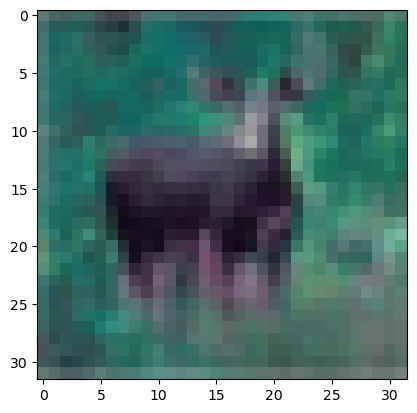

In [33]:
img, label = training_data[99]
plt.imshow(img.permute(1, 2, 0) * t.Tensor(DATASET_STD) + t.Tensor(DATASET_MEAN))

### Learning with Convolutions
![](imgs/learning-with-conv.png)

### Maxpooling
![](imgs/maxpooling.png)